# Sentiment Analysis using BERT

CODE ALMOST ALL FROM: https://www.kaggle.com/code/prakharrathi25/sentiment-analysis-using-bert
THE DATASET I USED: https://github.com/dxlabskku/Mental-Health/blob/main/data/twitter_English.csv

### Import Libraries and Set the intial variables

In [2]:
!pip install transformers
!pip install numpy
!pip install pandas
!pip install seaborn
!pip install pylab
!pip install matplotlib
!pip install sklearn
!pip install textwrap
!pip install torch
!pip install warnings
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.1.1 -> 24.1.2
[notice] To update, run: python -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.1.1 -> 24.1.2
[notice] To update, run: python -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.1.1 -> 24.1.2
[notice] To update, run: python -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.1.1 -> 24.1.2
[notice] To update, run: python -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement pylab (from versions: none)
ERROR: No matching distribu

In [79]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# Misc.
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

In [4]:
# Set intial variables and constants
%config InlineBackend.figure_format='retina'

# Graph Designs
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# Random seed for reproducibilty
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Load the data

In [16]:

df2_d = pd.read_csv("datasets/d_tweets.csv")
print(df2_d.head())
df2_d = df2_d[["tweet"]]



                    id      conversation_id    created_at  \
0  1261623711502753792  1261623711502753792  1.589630e+12   
1  1255537912491343872  1255537912491343872  1.588179e+12   
2  1255524270521761792  1255524270521761792  1.588175e+12   
3  1255524059334365186  1255524059334365186  1.588175e+12   
4  1172463022100512769  1172463022100512769  1.568372e+12   

                  date  timezone  place  \
0  2020-05-16 01:45:07     -1000    NaN   
1  2020-04-29 06:42:19     -1000    NaN   
2  2020-04-29 05:48:07     -1000    NaN   
3  2020-04-29 05:47:16     -1000    NaN   
4  2019-09-13 00:52:22     -1000    NaN   

                                               tweet language hashtags  \
0  the real reason why you're sad? you're attache...       en       []   
1      my biggest problem is overthinking everything       en       []   
2  the worst sadness is the sadness you've taught...       en       []   
3  i cannot make you understand. i cannot make an...       en       []   
4  i

In [17]:
df2_d['label'] = [1] * len(df2_d['tweet'])

df2_nd = pd.read_csv("datasets/non_d_tweets.csv")
df2_nd = df2_nd[["tweet"]]
df2_nd['label'] = [0] * len(df2_nd['tweet'])
print(len(df2_nd['label']))
df = pd.concat([df2_d, df2_nd])
df.reset_index(inplace = True)
df['tweet'] = df['tweet'].astype(str)

4809


We can see that the most relevant column for us is content and replyContent and the score as well.

In [18]:
df.iloc[4].tweet

"i don't think anyone really understands how tiring it is to act okay and always be the 'strong' one when in reality you're close to the edge."

We can see that we have more positive classes than negative and low number of neutral class. I have kept neutral less to focus more on positive and negative classes. Let's allot classes based on scores now.

* 0 - negative
* 1 - neutral
* 2 - positive

In [22]:
# Plot the distribution
class_names = ['not depressed', 'depressed']


## Data Preprocessing

Machine Learning models don’t work with raw text. You need to convert text to numerical representation. BERT requires even more attention when it comes to this representation.

Here are the requirements:

* Add special tokens to separate sentences and do classification
* Pass sequences of constant length (introduce padding)
* Create array of 0s (pad token) and 1s (real token) called attention mask

BERT offers a few model architectures and I will be using one of them combined with manual preprocessing. I am using the cased version which considers GREAT and great to be to different entities and BAD might be given more focus than bad.  

The tokenizer will break the sentence into words and give numerical values to each word.

In [23]:
# Set the model name
MODEL_NAME = 'bert-base-cased'

# Build a BERT based tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME, force_download=True)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [24]:
# Some of the common BERT tokens
print(tokenizer.sep_token, tokenizer.sep_token_id) # marker for ending of a sentence
print(tokenizer.cls_token, tokenizer.cls_token_id) # start of each sentence, so BERT knows we’re doing classification
print(tokenizer.pad_token, tokenizer.pad_token_id) # special token for padding
print(tokenizer.unk_token, tokenizer.unk_token_id) # tokens not found in training set

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


BERT works with fixed-length sequences. We’ll use a simple strategy to choose the max length. Let’s store the token length of each review.

In [25]:
# Store length of each review
token_lens = []

# Iterate through the content slide
for txt in df.tweet:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Text(0.5, 0, 'Token count')

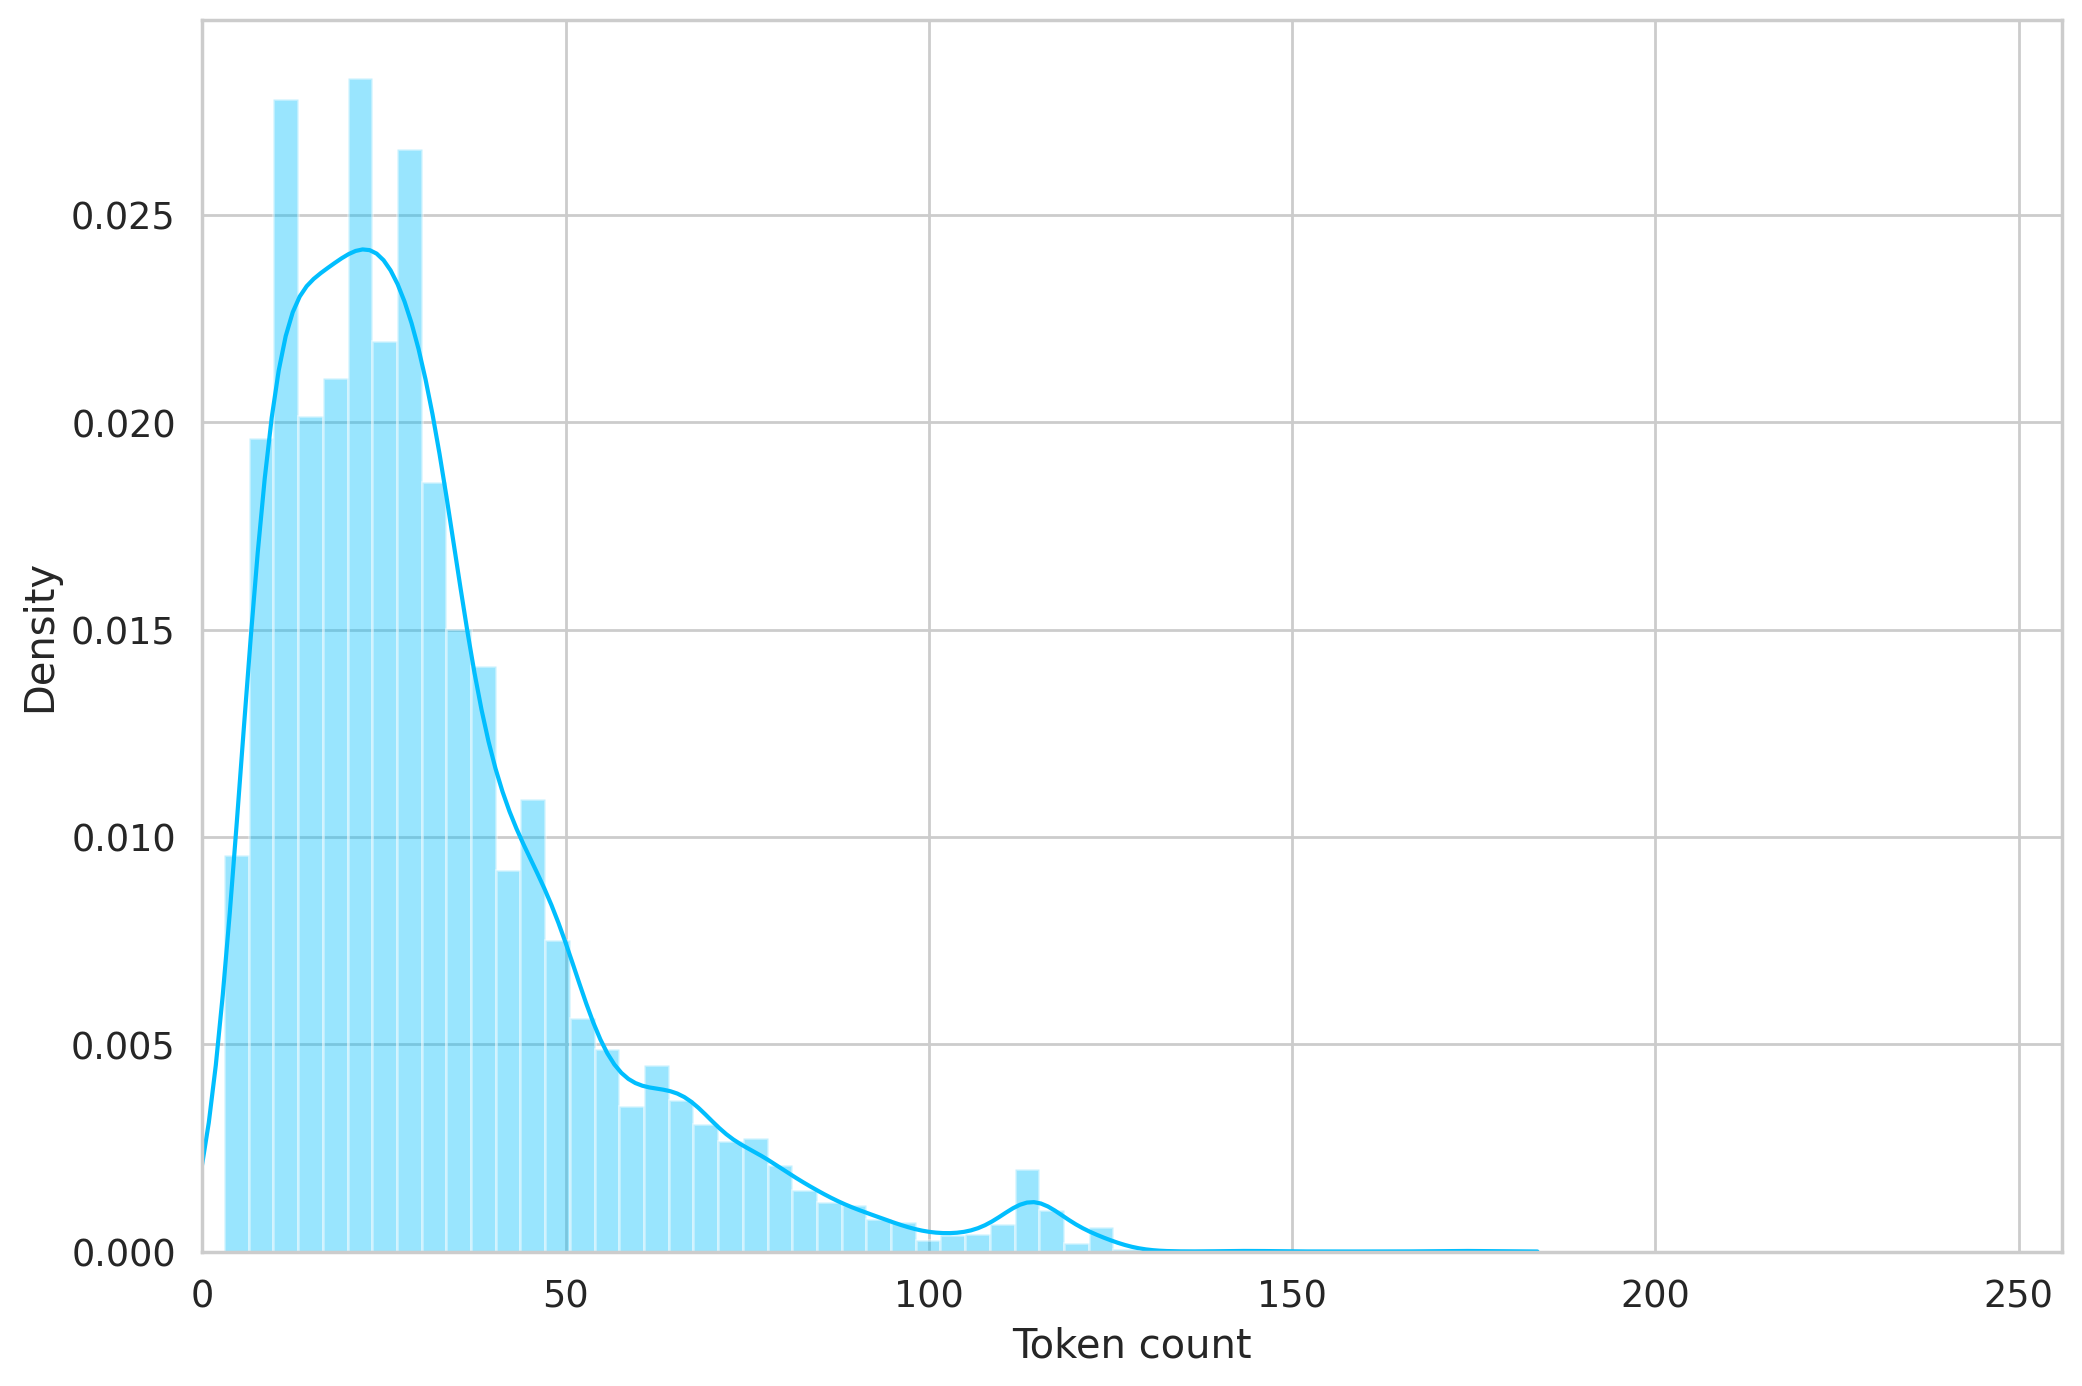

In [26]:
# plot the distribution of review lengths
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count')

Most of the reviews seem to contain less than 120 tokens, but we’ll be on the safe side and choose a maximum length of 160.

In [27]:
MAX_LEN = 160

### Preparing Torch Dataset

To enter data into a PyTorch, we need a more robust data generator class. We will return the review text as well to validate our predictions easily.

In [28]:
class GPReviewDataset(Dataset):
    # Constructor Function
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    # Length magic method
    def __len__(self):
        return len(self.reviews)

    # get item magic method
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]

        # Encoded format to be returned
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

Create a 80% train data and 10% test and 10% validation data

In [29]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

print(df_train.shape, df_val.shape, df_test.shape)

(6644, 3) (830, 3) (831, 3)


Create a dataloader to release data in batches.

In [30]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.tweet.to_numpy(),
        targets=df.label.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

In [31]:
# Create train, test and val data loaders
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [32]:
# Examples
data = next(iter(train_data_loader))
print(data.keys())

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


In [33]:
data

{'review_text': ['Am I an adult yet  https://t.co/eYEnv2dkHg',
  "Talking about anorexia, depression, drug abuse and suicide in health class makes me realize that I'm fat, ugly and I shouldn't be here.. 😔😞😓",
  "i'm a really hard person to understand. i have major issues with talking about all my feelings and thoughts and i'm really sorry, i'm trying",
  "So used to being ignored, but it's so painful everytime. It makes me feel like I'm not worth the time which...I guess I'm not.",
  'ignore me in a hot way',
  'Had an impassioned discussion with my friend @JakeTapper about the Marvel and DC cinematic universes. I’m firmly #antiportal.  https://t.co/pfOk23nSHZ  https://t.co/i0aaGNt9MI',
  'New Improved Audio content update available!   https://t.co/n480kEaa2I Download today and get 20 guided meditations delivered in Iyanla’s soothing voice to help navigate through the global health crisis and other life experiences. #iyanla #iyanlameditations #mindmattersmeditations  https://t.co/X0rAX

## Sentiment Classification with BERT and Hugging Face

We’ll use the basic BertModel and build our sentiment classifier on top of it. Let’s load the model

In [34]:
# Load the basic BERT model
bert_model = BertModel.from_pretrained(MODEL_NAME)

In [35]:
# Build the Sentiment Classifier class
class SentimentClassifier(nn.Module):

    # Constructor class
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    # Forward propagaion class
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask,
          return_dict=False
        )
        #  Add a dropout layer
        output = self.drop(pooled_output)
        return self.out(output)

We use a dropout layer for some regularization and a fully-connected layer for our output. We are returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work. Create an instance and move it to the GPU

In [36]:
# Instantiate the model and move to classifier
model = SentimentClassifier(len(class_names))
model = model.to(device)

#### Model Characterstics

In [37]:
# Number of hidden units
print(bert_model.config.hidden_size)

768


### Training Phase

we’ll use the AdamW optimizer provided by Hugging Face. It corrects weight decay. We’ll also use a linear scheduler with no warmup

In [38]:
# Number of iterations
EPOCHS = 4

# Optimizer Adam
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Set the loss function
loss_fn = nn.CrossEntropyLoss().to(device)

In [82]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples, progress_bar=None):
    model = model.train()
    losses = []
    correct_predictions = 0

    
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        # Backward prop
        loss.backward()

        # Gradient Descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        if progress_bar:
            progress_bar.update(1)

    return correct_predictions.double() / n_examples, np.mean(losses)


Write a function to evaluate model performance

In [83]:

def eval_model(model, data_loader, loss_fn, device, n_examples, progress_bar=None):
    model = model.eval()
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            # Update progress bar
            if progress_bar:
                progress_bar.update(1)

    return correct_predictions / n_examples, np.mean(losses)


Write the training Loop and store the best training state.

In [84]:
model

SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, eleme

In [85]:

from tqdm import tqdm

# Assume the necessary imports for train_epoch and eval_model are already done

EPOCHS = 4  # Example, set your number of epochs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define model, loss_fn, optimizer, scheduler, train_data_loader, val_data_loader, df_train, df_val
# Assume these are already defined in your code

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)

    # Initialize the progress bar for training
    train_progress_bar = tqdm(total=len(train_data_loader), desc="Training", position=0, leave=True)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train),
        train_progress_bar  # Pass the progress bar to your train_epoch function
    )

    print(f"Train loss {train_loss} accuracy {train_acc}")

    # Initialize the progress bar for validation
    val_progress_bar = tqdm(total=len(val_data_loader), desc="Validation", position=0, leave=True)

    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val),
        val_progress_bar  # Pass the progress bar to your eval_model function
    )

    print(f"Val   loss {val_loss} accuracy {val_acc}")
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/4
----------


Training: 100%|██████████████████████████████▉| 415/416 [01:49<00:00,  3.53it/s]

Train loss 0.009626220330189356 accuracy 0.9977423239012643


Validation:  98%|██████████████████████████████▍| 51/52 [00:05<00:00,  9.93it/s]

Val   loss 0.2899998782147752 accuracy 0.9469879865646362

Epoch 2/4
----------


Training: 100%|██████████████████████████████▉| 415/416 [01:56<00:00,  3.69it/s]

Train loss 0.011406412653566523 accuracy 0.99789283564118


Validation: 100%|███████████████████████████████| 52/52 [00:04<00:00, 10.87it/s]

Val   loss 0.2899998782147752 accuracy 0.9469879865646362

Epoch 3/4
----------


Training:  16%|█████▏                          | 68/416 [00:17<01:26,  4.02it/s]

KeyboardInterrupt: 

The above took a lot of time but it's finally working. Now, we can plot the training and validation accuracy.

In [43]:
history

defaultdict(list,
            {'train_acc': [tensor(0.9106, device='cuda:0', dtype=torch.float64),
              tensor(0.9755, device='cuda:0', dtype=torch.float64),
              tensor(0.9931, device='cuda:0', dtype=torch.float64),
              tensor(0.9970, device='cuda:0', dtype=torch.float64)],
             'train_loss': [0.23883866397619175,
              0.0841406982511986,
              0.030912042668310626,
              0.013312417056288094],
             'val_acc': [tensor(0.9482, device='cuda:0', dtype=torch.float64),
              tensor(0.9494, device='cuda:0', dtype=torch.float64),
              tensor(0.9506, device='cuda:0', dtype=torch.float64),
              tensor(0.9470, device='cuda:0', dtype=torch.float64)],
             'val_loss': [0.17245616882932013,
              0.23815600516480537,
              0.26985942433720295,
              0.2899998782147752]})

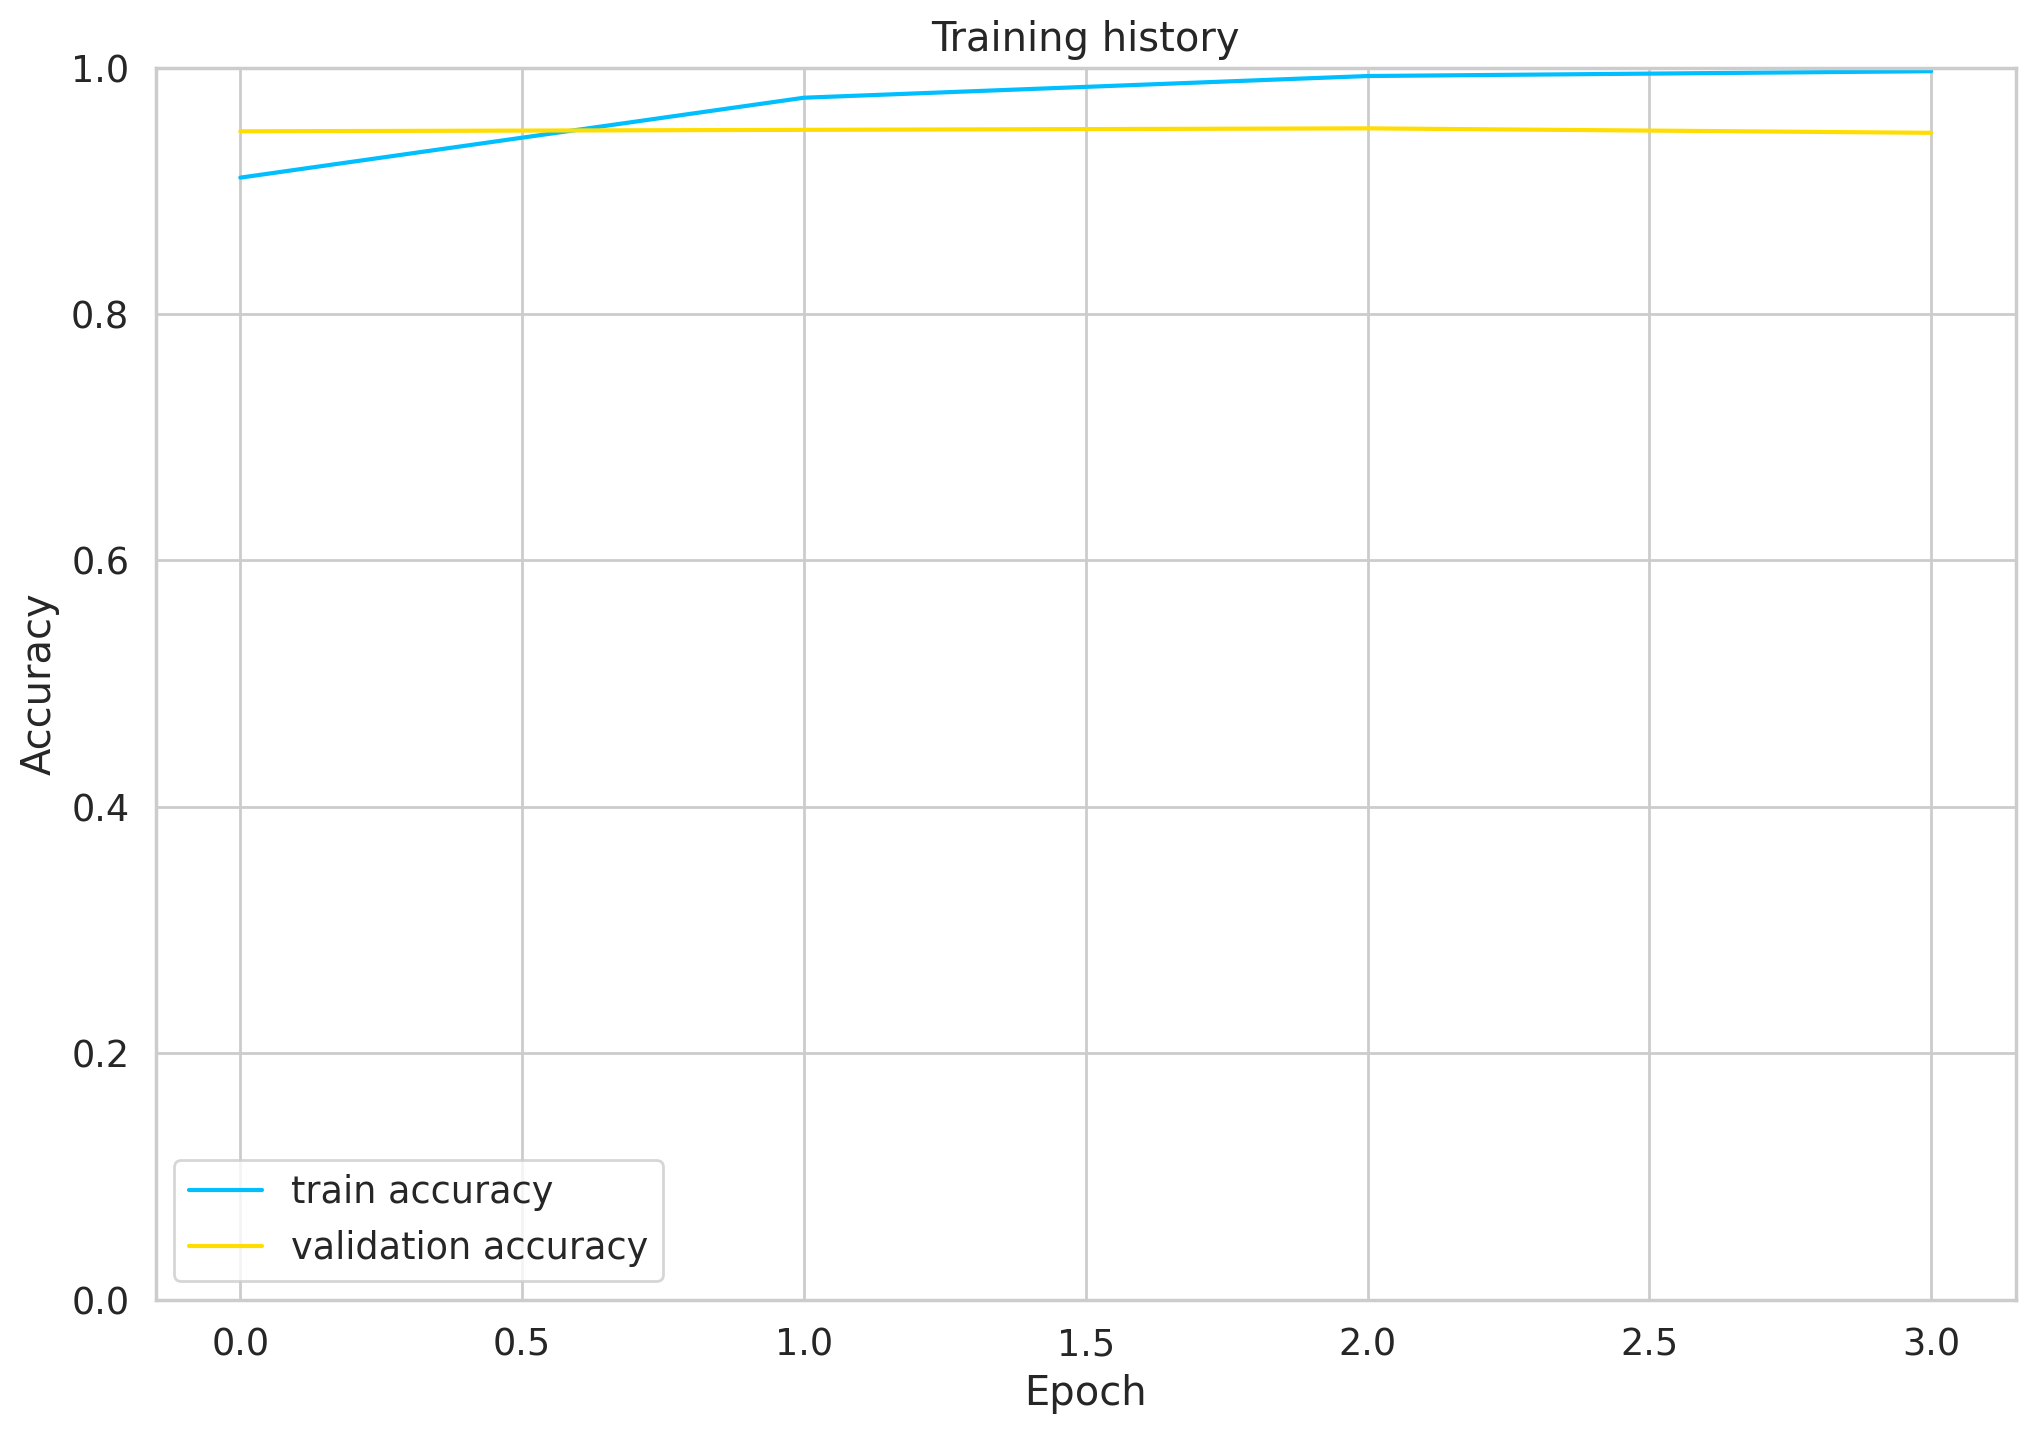

In [44]:
# Plot training and validation accuracy
plt.plot(list(map(lambda x: x.cpu(), history['train_acc'])), label='train accuracy')
plt.plot(list(map(lambda x: x.cpu(), history['val_acc'])), label='validation accuracy')

# Graph chars
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

### Model Evaluation

In [45]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.9554753309265945

Define a helper function to get predictions from our models. This is similar to the evaluation function, except that we’re storing the text of the reviews and the predicted probabilities

In [46]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get outouts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return review_texts, predictions, prediction_probs, real_values

In [47]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)

In [48]:
print(classification_report(y_test, y_pred, target_names=class_names))

               precision    recall  f1-score   support

not depressed       0.98      0.94      0.96       477
    depressed       0.93      0.97      0.95       354

     accuracy                           0.96       831
    macro avg       0.95      0.96      0.95       831
 weighted avg       0.96      0.96      0.96       831



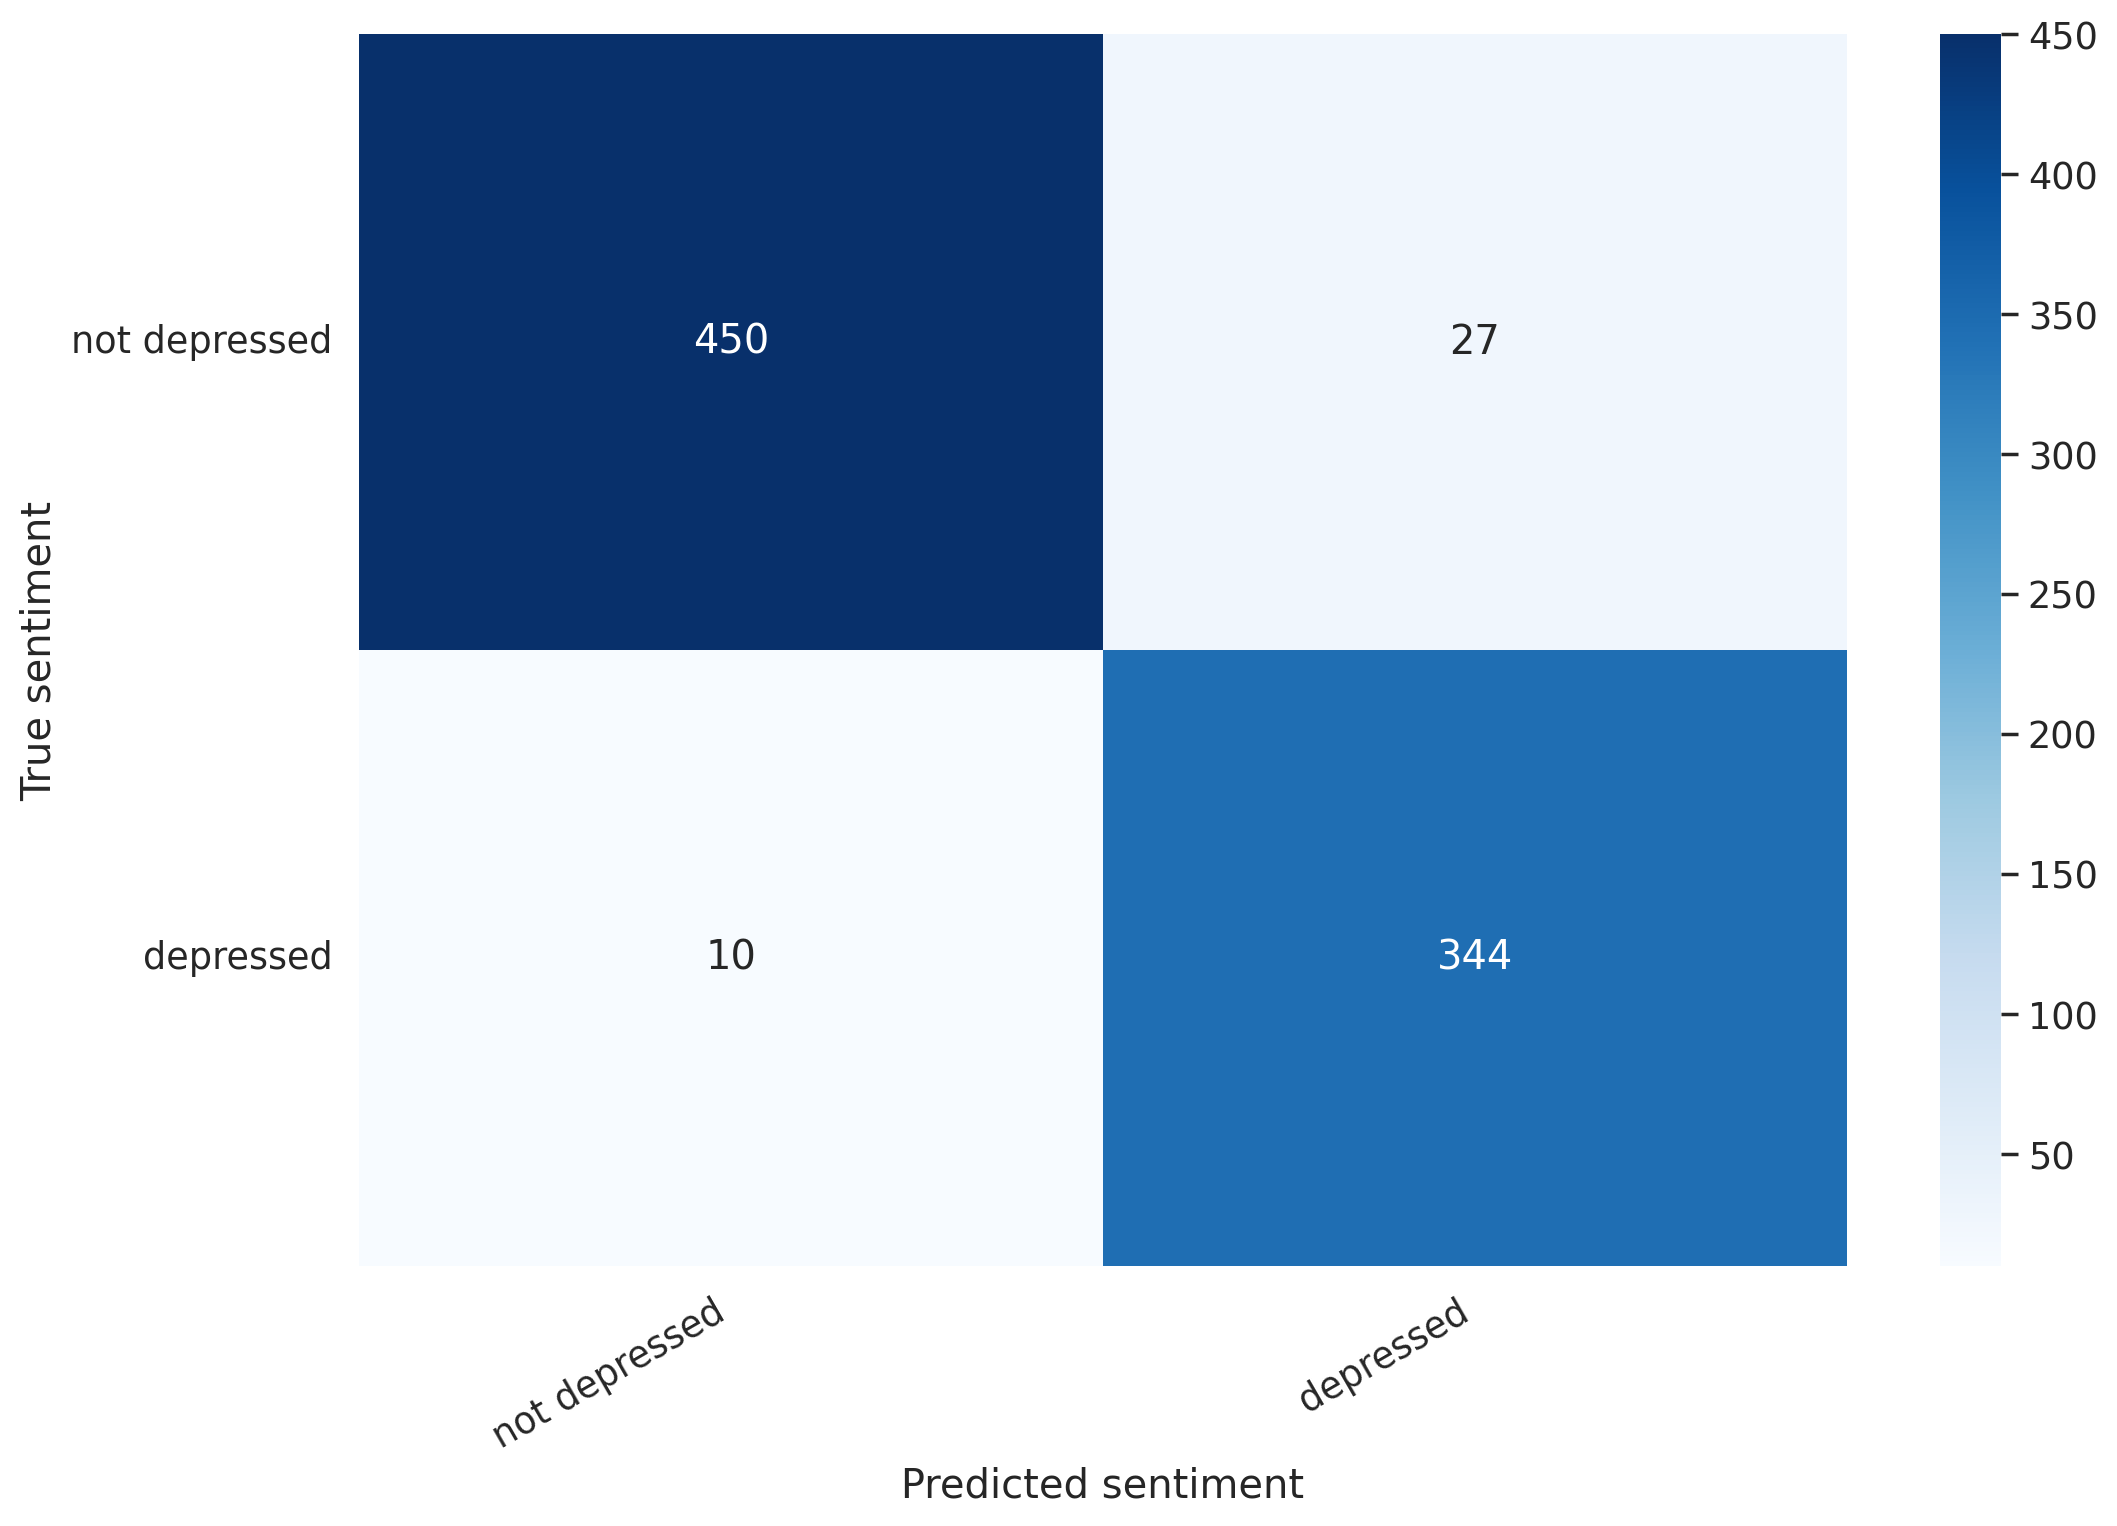

In [49]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

This confirms that our model is having difficulty classifying neutral reviews. It mistakes those for negative and positive at a roughly equal frequency.

That’s a good overview of the performance of our model.

## Predicting on raw text

In [103]:
test_texts = [
    "i hate life", 
    "i love life", 
    "life", 
    "life is fun", 
    "thats great lol", 
    "mushrooms are fungi, some of which are edible.", 
    "Mushrooms are fungi, some of which are edible.", 
    "Parties are life!", 
    "this is the best day ever!", 
    "a polynomial is an expression of more than two algebraic terms, especially the sum of several terms that contain different powers of the same variable(s).",
    "On behalf of the American people, I thank Joe Biden for his extraordinary leadership as President of the United States and for his decades of service to our country.",
    "So many interesting people are following me. I think I'll follow some of you guys as well.",
    "erm what the sigma",
    "Just thinking:  If we were snakes or any other horizontal vertebrate, the concept of “portrait” framing in photos they take of each other might be one and the same as “landscape.”",
    "lets gooo hoplite leaderboard",
    "A heavy dose of Seoul is highly recommended to anyone and everyone.  🇰🇷🇰🇷🇰🇷#DeadpoolAndWolverine",
    "Im happy but i hate my life but im super happy and joyful but I want to end my self",
    "wowzers",
]
for t in test_texts:
    review_text = t
    encoded_review = tokenizer.encode_plus(
        review_text,
        max_length=MAX_LEN,
        add_special_tokens=True,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt',
    )
    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)
    
    output = model(input_ids, attention_mask)
    print(float(output[0][0] + output[0][1]))
    _, prediction = torch.max(output, dim=1)
    
    print(f'Review text: {review_text}')
    print(f'Sentiment  : {class_names[prediction]}')

-0.6562511920928955
Review text: i hate life
Sentiment  : depressed
-0.5801548957824707
Review text: i love life
Sentiment  : depressed
-1.0498898029327393
Review text: life
Sentiment  : depressed
-0.18886327743530273
Review text: life is fun
Sentiment  : depressed
-0.1787090301513672
Review text: thats great lol
Sentiment  : depressed
-0.7840621471405029
Review text: mushrooms are fungi, some of which are edible.
Sentiment  : depressed
0.8463315963745117
Review text: Mushrooms are fungi, some of which are edible.
Sentiment  : not depressed
0.2489774227142334
Review text: Parties are life!
Sentiment  : not depressed
-0.12220191955566406
Review text: this is the best day ever!
Sentiment  : not depressed
0.3639562129974365
Review text: a polynomial is an expression of more than two algebraic terms, especially the sum of several terms that contain different powers of the same variable(s).
Sentiment  : not depressed
1.1254899501800537
Review text: On behalf of the American people, I thank 

In [70]:
torch.save(model.state_dict(), "model.pt")

In [52]:
test = torch.load("/content/model.pt")

print(type(model))

<class '__main__.SentimentClassifier'>


In [73]:
model = SentimentClassifier(len(class_names))
model.load_state_dict(test)
model.cuda()


SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, eleme